# Cropping Raster image into 150 by 150 pixel tiles 
----

### Script Description  
-----

This script takes large raster files in the form of '.tif' or '.img' files and breaks them up into tiles which are 150 pixels by 150 pixels. The output is a large number of these 150x150 tiles, with their colour channels corrected, which can be fed into the CNN Neural Network. 

The process can be broken into the following steps: 

___Step 1: Generate the tile dimensions___

To crop the raster into the specified tile sizes, we can treat the image as a numpy array where the pixel locations are indicated using rows and columns. With this approach, we 1) find the row and column of the pixel in the upper left corner of the tile, 2) use this to find the centre coordinate by adding the tile height/width and dividing by 2. We then 3) transform the row and column values of the pixels into geographic coordinates which are 4) zipped together into a tuple and converted to a spatial 'point'. Finally, 5) all information is saved into a GeoDataFrame, from where it can be used. 

___Step 2: Crop the image into tiles___

Rasterio's 'mask()' function is then used to crop the images, according to the dimensions calculated in step 1. The centre x and y coordinates are used to build a bounding box out from that point, where the bounds of the box are saved into a GeoJSON dictionary object which is fed to the mask function. Each cropped file is saved into the output directory of choice and the meta data is updated for each. 

___Step 3: Merge the colour channels___

The CNN needs the images to be in the same style as the 3-band images on which it was trained. However, many raster images have 4 colour bands which will impact the CNN's ability to acurately classify. Thus, the 4th colour band 'InfraRed' is merged into the red colour band, to make the images 3-band colour images. This is done using min-max normalisation of each colour channel and stacking the 3 desired colour channels into 16-bit 3D arrays, which can be saved as .png images. 

__To Note__

Due to the rasterio.mask function not being able crop beyond the bounds of the original (big) raster image, we are unable to include and areas which fall beyond the last 150 by 150 square which fits into the image. This means there is a small dataloss at the right hand side and bottom of the larger raster image which should be remembered when using the pipeline. 

_Notes describing this can be found at the bottom of the script_


___The script takes the following structure:___ 
- Setup
- Functions
- West Raster 
- East Raster 
- Merged Raster 
- Merging the colour channels 
- Notes 
- Worked example (_breaking the functions into chunks_)

## Setting up the project
-----

#### GIS packages used: 

__rasterio__ = a GDAL and Numpy-based Python library designed to make working with geospatial raster data more productive. This package reads and writes geospatial raster data. It is python software, not GIS software, meaning it makes use of Python's language types, protocols, and idioms. Documentation can be found here: https://rasterio.readthedocs.io/en/latest/ 

__geopandas__ = A spatial package modelled on pandas which is necessary for manipulating the meta-data in the shape (.shp) files. 

In [5]:
#These are only necessary if you're using the script without setting up a virtual environment 
#!pip install rasterio          
#!pip install geopandas         
#!pip install ipympl 

__Load in the Dependencies__

In [3]:
#Operating system 
import os
import sys
%matplotlib notebook

#Data handling packages 
import numpy as np      
import matplotlib.pyplot as plt
import glob
from PIL import Image

#Geospatial packages 
import rasterio
from rasterio import features
from rasterio.mask import mask
from rasterio.transform import TransformMethodsMixin
from rasterio.coords import BoundingBox
from rasterio.windows import Window
import rasterio.plot as rplt
from shapely.geometry import Polygon
from shapely.geometry import Point
import geopandas as gpd

__Data paths__

_New users will need to ammend these to fit their own project folder structure_ 

In [4]:
#path to the WEST image we're using 
West_file_path = "/work/proj/TRAP_Data/West/kaz_w_fuse.img"

In [5]:
#path to the EAST image we're using 
East_file_path = "/work/proj/TRAP_Data/East/kaz_e_fuse.img"

In [6]:
#Path to the MERGED image we're using 
Merged_file_path = "/work/proj/TRAP_Data/kaz_fuse.img"

In [ ]:
#Path to the output directory 'out'
outDir = '/work/proj/DataAnalysis/Pre-Processing/out/'

__Read in the raster images__

In [8]:
West_raster = rasterio.open(West_file_path)

In [9]:
East_raster = rasterio.open(East_file_path)

In [10]:
Merged_raster = rasterio.open(Merged_file_path)

_Inspect the shape of the merged raster to see how many tiles we can expect_

In [11]:
Merged_raster.shape

(28366, 22610)

In [12]:
#create copies of these incase there's an overwrite issue
West_raster_orig = West_raster
East_raster_orig = East_raster
Merged_raster_orif = Merged_raster

__Get the shapes of each raster__

In [13]:
print("West raster shape: Width:", West_raster.shape[1], "Height:", West_raster.shape[0], "\n")

print("East raster shape: Width:", East_raster.shape[1], "Height:", East_raster.shape[0], "\n")

print("Merged raster shape: Width:", Merged_raster.shape[1], "Height:", Merged_raster.shape[0], "\n")

West raster shape: Width: 12401 Height: 27817 

East raster shape: Width: 12337 Height: 28173 

Merged raster shape: Width: 22610 Height: 28366 



__Plot the MERGED raster__

In [30]:
%matplotlib inline 

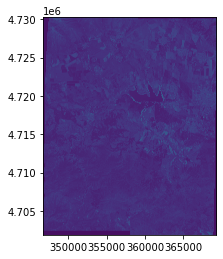

In [31]:
#Beware - this takes some time to run! 
ax1 = rplt.show(Merged_raster)

_Some things to note about this image:_ 

The Raster does not fit perfectly into the rectangular border - with some regions in the upper left, lower left and lower right corners being without land data. This should not be a problem for the neural network as it should just classify these regions as "non-mounds". 

However, we could consider also adding a step into the pre-processing pipeline that filters out any tile which has >95% of the tile with the same pixel intensity. 

## Functions
-----

1. _extract_tile_dimensions()_
2. _generate_polygon()_
3. _crop_tile()_
4. _get_zscores()_
5. _merge_colour()_

_These functions can be found in the 'Preprocessing_Utils.py' script found in the utils folder_

### 1. extract_tile_dimensions()

A function to extract the rows, columns, bounds, and centroids of the tiles to be created.

_Returns a GeoDataFrame object containing this information_ 

In [16]:
def extract_tile_dimensions(rasterData, crs_code, imageWidth = 150, imageHeight = 150):
    """
    Set-up the lists and counters 
    """
    # ------------------ Create image and dimension counters ---------------------------
    #dynamic image counters 
    image_counter = 0
    image_idx = []
    
    #dynamic dimension counters 
    #to keep track of the moving sides 
    col_off = 0
    row_off = 0
    
    
    # ------------- Create lists to store the pixel rows, columns, and  x/y coordinates of image ------
    
    #row and column of the tile's upper left corner
    row_upper_left = []
    column_upper_left = []
    
    #row and column of the tile's centre point 
    row_centre = []
    column_centre = []
    
    #The x and y coordinates of the tile's centre point
    x_coordinate = []
    y_coordinate = []
    
    
    # ------------------ Define the static width and height of the cutout tile --------------------
    width = imageWidth
    height = imageHeight
    
    
    """
    Get the number of tiles that fit into the height and width dimensions of the raster image
    """
    
    # ------------------ HEIGHT ----------------------------
    # Get the height of the image 
    no_boxes_height = rasterData.shape[0]
    
    #divide it by the height of the tiles 
    no_boxes_height = no_boxes_height / height
    
    #round decimal down to integer, to ensure all tiles fit within the raster image
    no_boxes_height = int(no_boxes_height) 
    
    
    # ------------------ WIDTH ---------------------------- 
    # Get the height of the image 
    no_boxes_width = rasterData.shape[1]
    
    #divide it by the height of the tiles 
    no_boxes_width = no_boxes_width / width
    
    #round decimal down to integer, to ensure all tiles fit within the raster image
    #python will always round down 
    no_boxes_width = int(no_boxes_width) 
    
    
    """
    Loop through the image and use the dimensions to extract x and y coordinates for each tile 
    """
    
    # ------------------ Step 1: Find the row and column values of our upper left corners -------------
    
    ### i represents the height of the image, where we know we can fit 'no_boxes_height' down 
    ### j represents the width of the image, where we know we can fit 'no_boxes_width' across
    ### Note this style means the pixels outside the last boxes on each side will be excluded from tiles
    for i in range(0, no_boxes_height):
        for j in range(0, no_boxes_width):
            #update counters and image index 
            image_counter = image_counter + 1
            image_idx.append(image_counter)
            
            #Get the row and columns 
            row_off = i * height
            col_off = j * width 
        
            #save these as the UL corner of image 
            column_upper_left.append(col_off)
            row_upper_left.append(row_off)
            
            # ------------------ Step 2: Get the center pixel values of the window -------------------
            centre_x = int(col_off + width/2)
            centre_y = int(row_off + height/2)
        
            #Save the row and column of centre point
            column_centre.append(centre_x) 
            row_centre.append(centre_y)
            
            # ------------------ Step 3: Transform the centre row/column into x and y points ----------
            x, y = rasterData.transform * (centre_x, centre_y)
            x_coordinate.append(x)
            y_coordinate.append(y)
    
    print(f"Finished getting dimensions! you have {image_counter} images") 
            
    """
    Create a spatial GeoDataFrame  
    """
    
    # ------------------ Create a spatial point ----------------------------------
     
    #First, create a tuple with our x and y coordinates 
    geometry = list(zip(x_coordinate, y_coordinate))
    
    #Next, make the geometry tuple a spatial point
    #Create empty list to store the points in 
    Points = []

    #Loop through the geometry column and transform the tuple to a spatially recognised point
    for i in geometry:
        pnt = Point(i[0], i[1])
        Points.append(pnt)

    #Check format
    print(f"\n[Data-check] The first point has the following coordinates: {Points[0]} \n")
    
    
    # ------------------ Ensure all points are within the raster area ------------------
    
    #Create a list of raster_bound_coordinates using generate_polygon() function 
    raster_bound_coordinates = generate_polygon(rasterData.bounds)
    print(f"[Data-check] The raster's bounds are: {raster_bound_coordinates}\n")
    
    #Create a polygon and check all points fall within it 
    raster_area = Polygon([(raster_bound_coordinates[0]), (raster_bound_coordinates[1]), 
                           (raster_bound_coordinates[2]), (raster_bound_coordinates[3])])
    
    #Loop through the points and ensure they're all within the bounds
    #If nothing is printed that means all images are within the bounds
    for pnt in Points:
        if pnt.within(raster_area):
            pass
        else: 
            print(f"\nPoint of coordinates: {pnt} is not in the bounding box.\n") 
            
            
    # ------------------ Put all information into GeoDataFrame -------------------------
    
    #Create geodataframe 
    tile_dimensions = gpd.GeoDataFrame({
        
        'image_idx': image_idx, 
        'row_upper_left': row_upper_left,
        'column_upper_left': column_upper_left,
        'row_centre': row_centre,
        'column_centre': column_centre,
        'x_coordinate': x_coordinate,
        'y_coordinate': y_coordinate,
        'geometry': Points}) 
    
    #Reset the index to the image number 
    tile_dimensions = tile_dimensions.set_index('image_idx')

    # ------------------ reset the CRS -------------------------
    
    #Check the crs of the original data 
    print(f"\nThe original raster's CRS is: {rasterData.crs}\n")
    
    #Set the tile_dimensions crs to the desired crs 
    tile_dimensions = tile_dimensions.set_crs(crs_code)
    
    #Check the new CRS 
    print(f"The tile_dimensions CRS is now {tile_dimensions.crs}. This should match the original raster's CRS above.")
    
    print("\nYour information is saved as a GeoDataFrame.")
    
    return x_coordinate, y_coordinate, tile_dimensions
    

### 2. generate_polygon()

_A function to get the spatial bounds (coordinates) of tile's bounding box_ 

_Returns a list of tuples_ 

In [17]:
 def generate_polygon(bbox):
    """
    Generates a list of coordinates: [[x1,y1],[x2,y2],[x3,y3],[x4,y4],[x1,y1]]
    """
    return [[bbox[0],bbox[1]],
             [bbox[2],bbox[1]],
             [bbox[2],bbox[3]],
             [bbox[0],bbox[3]],
             [bbox[0],bbox[1]]]

### 3. crop_tile()

_A function to crop the raster into the desired tile dimensions using rasterio's mask() function_ 

_The output is the tile images saved to the chosen directory_ 

In [18]:
def crop_tile(rasterData, x, y, imageClass, outPrefix=None, imageSize=150):

    """
    Get the min and max values of our tile's bounding point, using the centre point(x,y)
    """
    #Round the x and y values
    x = round(x+0.5)-0.5
    y = round(y+0.5)-0.5
    
    #Get the bounds of the tile 
    xMin = float(x - imageSize/2.)
    yMin = float(y - imageSize/2.)
    xMax = float(x + imageSize/2.)
    yMax = float(y + imageSize/2.)
    
    """
    Create a GeoJSON dict object
    """ 
    # This is the format necessary for the rasterio package to mask the image (ie crop it) 
    #There are 5 sides as it needs to be a 'closed' polygon
    polyCoords = [[[xMax, yMin], [xMax, yMax], [xMin, yMax], 
                   [xMin, yMin], [xMax, yMin]]]
    polyDict = {'type': 'Polygon', 'coordinates': polyCoords}
        
    """
    Crop the image from the main raster using mask 
    """ 

    # Now use the mask function of rasterio to clip the data
    outData, outTrans = mask(dataset=rasterData, 
                             shapes=[polyDict],
                             all_touched=True, 
                             crop=True)
                
    """
    Update the metadata  
    """ 
    # Copy the metadata from the original file and modify to reflect changes
    # We are not changing CRS, so don't need to update
    outMeta = rasterData.meta.copy()
    outMeta.update({"driver": "GTiff",
                    "height": outData.shape[1],
                    "width": outData.shape[2],
                    "transform": outTrans})
    
            
    """
    Format the filename for the image  
    """ 

    # Format the output file name and create the output directory(s)
    imageClass = imageClass
    
    if outPrefix is None:
        outPrefix = "IMG_{:.4f}_{:.4f}_{:d}".format(x, y, imageSize)
    if not os.path.exists(outDir + imageClass + "/"):
         os.makedirs(outDir + imageClass + "/")
    outPath = outDir  + imageClass + "/" + outPrefix + ".tif"
    
    """
    Save the cropped image as .tif file 
    """ 
    if os.path.exists(outPath):
        os.remove(outPath)
    with rasterio.open(outPath, "w", **outMeta) as FH:
        FH.write(outData)
    

### 4. get_zscores()

_A function to get zLow and zHigh values of the original raster image based on each colour band's min and max values._ 

_Returns two scores: zLow and zHigh_ 

In [16]:
def get_zscores(rasterData):
    zLow = None     #create placeholder variable for the minimum value 
    zHigh = None    #create placeholder variable for the maximum value
    
    #Create empty list for storing the band information 
    zMinLst = []
    zMaxLst = []
    zStdLst = []
    zMedLst = []
    
    #Loop through each band and find the min/max/std/median values
    #We're adding 1 to the counter because python starts indexing at 0
    for iBand in range(1, rasterData.count+1):
        print(" {:d} ...".format(iBand), end="", flush=True)
        bandArr = rasterData.read(iBand)       
        zMinLst.append(np.nanmin(bandArr))             #returns minimum of an array while ignoring Na's
        zMaxLst.append(np.nanmax(bandArr))             #returns maximum of an array while ignoring Na's
        zStdLst.append(np.nanstd(bandArr))             #returns std of an array while ignoring Na's
        zMedLst.append(np.nanmedian(bandArr))          #returns median of an array while ignoring Na's
        
    #Find the min/max/std/median values from the lists 
    zMin = np.min(zMinLst)
    zMax = np.max(zMaxLst)
    zStd = np.max(zStdLst)
    zMed = np.max(zMedLst)
    
    print("[INFO] Range = ({:.1f}, {:.1f}), Med = {:.1f}, Stdev = {:.1f}"\
          .format(zMin, zMax, zMed, zStd))
    
    #Save as variables 
    zLow = np.max([0.0, zMin])     #clip at 0 
    zHigh = zMed + zStd * 5.        #clip at 5 stds 
    
    print(f"[INFO] zLow = {zLow}, and zHigh = {zHigh}")
    
    return zLow, zHigh 

### 5. merge_colour()

_A function to merge the 4 colour bands into 3_ 

_Output: all tiles are saved as new .png images into the indicated RGB output directory_ 

In [19]:
def merge_colour(rasterData, x, y, imageClass, rgbPrefix = None, imageSize=150, rgbBands=[4, 3, 2],
                 zLow=None, zHigh=None):

    """
    Get the min and max values of our tile's bounding point, using the centre point(x,y)
    """
    #Round the x and y values
    x = round(x+0.5)-0.5
    y = round(y+0.5)-0.5
    
    #Get the bounds of the tile 
    xMin = float(x - imageSize/2.)
    yMin = float(y - imageSize/2.)
    xMax = float(x + imageSize/2.)
    yMax = float(y + imageSize/2.)
    
    """
    Create a GeoJSON dict object
    """ 
    # This is the format necessary for the rasterio package to mask the image (ie crop it) 
    #There are 5 sides as it needs to be a 'closed' polygon
    polyCoords = [[[xMax, yMin], [xMax, yMax], [xMin, yMax], 
                   [xMin, yMin], [xMax, yMin]]]
    polyDict = {'type': 'Polygon', 'coordinates': polyCoords}
        
    """
    Crop the image from the main raster using mask 
    """ 

    # Now use the mask function of rasterio to clip the data
    outData, outTrans = mask(dataset=rasterData, 
                             shapes=[polyDict],
                             all_touched=True, 
                             crop=True)
        
    """
    Create an RGB image with 3 colour bands   
    """ 
    #Create an RGB outPrefix 
    if rgbPrefix is None:
        rgbPrefix = "RGB_{:.4f}_{:.4f}_{:d}".format(x, y, imageSize)
    
    #Link up the directories 
    if not os.path.exists(outDir + "RGB/" + imageClass + "/"):
        os.makedirs(outDir + "RGB/" + imageClass + "/")
        
    # Scale the data to the range 0-255 for RGB values
    outR = (outData[rgbBands[0]-1] - zLow) * 255.0 / (zHigh -zLow)
    outG = (outData[rgbBands[1]-1] - zLow) * 255.0 / (zHigh -zLow)
    outB = (outData[rgbBands[2]-1] - zLow) * 255.0 / (zHigh -zLow)
    
    # Convert to 16-bit and stack into a 3D array
    outR = outR.astype(np.uint8)
    outG = outG.astype(np.uint8)
    outB = outB.astype(np.uint8)
    rgbArr = np.dstack((outR, outG, outB))
    
    # Write as a PNG file
    img = Image.fromarray(rgbArr)
    outRBGpath = outDir + "RGB/" + imageClass + "/"  + rgbPrefix + ".png"
    img.save(outRBGpath)
    



## WEST Raster 
-----

#### Step 1: Get the tile dimensions

In [ ]:
x, y, west_tile_dimensions = extract_tile_dimensions(West_raster, 
                                          imageHeight = 150, 
                                          imageWidth = 150,
                                          crs_code = 'epsg:32635')

_Inspect the output GeoDataFrame_

In [88]:
west_tile_dimensions.head(5)

,row_upper_left,column_upper_left,row_centre,column_centre,x_coordinate,y_coordinate,geometry
image_idx,,,,,,,
1,0,0,75,75,346775.115446,4.730165e+06,POINT (346775.115 4730164.941)
2,0,150,75,225,346925.115446,4.730165e+06,POINT (346925.115 4730164.941)
3,0,300,75,375,347075.115446,4.730165e+06,POINT (347075.115 4730164.941)
4,0,450,75,525,347225.115446,4.730165e+06,POINT (347225.115 4730164.941)
5,0,600,75,675,347375.115446,4.730165e+06,POINT (347375.115 4730164.941)


_Save West tile dimensions_

In [29]:
#Write this to a csv file 
csv_path = outDir + "/" + "GeoDataFrames" + "/" + "West_tile_dimensions.csv"
west_tile_dimensions.to_csv(csv_path)

#### Step 2: Crop the image 

_Beware: the below chunk takes some time to run_

In [31]:
#Crop the west images 
for index, row in west_tile_dimensions.iterrows():
    
    x = row["geometry"].x
    y = row["geometry"].y
    
    crop_tile(rasterData = West_raster, 
              x = x, 
              y  = y, 
              outPrefix=None, 
              imageSize=150,
              imageClass = "west150")

#### Step 3: Merge the colour channels 

_First: get the z_scores for the west image_

In [48]:
#Get the west zscores: beware this line takes a long time to run 
zLow_west, zHigh_west = get_zscores(West_raster)

 1 ... 2 ... 3 ... 4 ...[INFO] Range = (-724.0, 3304.0), Med = 503.0, Stdev = 144.1
[INFO] zLow = 0.0, and zHigh = 1223.4512023925781


_Next: merge the colour channels and save the new images to the RGB folder in 'out'_

In [50]:
#For every row in west_tile_dimensions, merge the colour channels
for index, row in west_tile_dimensions.iterrows():
    
    x = row["geometry"].x
    y = row["geometry"].y
    
    merge_colour(rasterData = West_raster, 
              x = x, 
              y  = y,
              imageClass = "west150",
              rgbPrefix=None, 
              imageSize=150, 
              zLow = zLow_west,
              zHigh = zHigh_west,
              rgbBands=[4, 3, 2])



## EAST Raster 
-----

#### Step 1: Get the tile dimensions

In [ ]:
x, y, east_tile_dimensions = extract_tile_dimensions(East_raster, 
                                          imageHeight = 150, 
                                          imageWidth = 150,
                                          crs_code = 'epsg:32635')

_Inspect the output GeoDataFrame_

In [ ]:
east_tile_dimensions.head(5)

_Save the east_tile_dimensions_

In [ ]:
#Write this to a csv file 
csv_path_east = outDir + "/" + "GeoDataFrames" + "/" + "East_tile_dimensions.csv"
east_tile_dimensions.to_csv(csv_path_east)

#### Step 2: Crop the image

_Beware: the below chunk takes some time to run_

In [ ]:
#Crop the east images 
for index, row in east_tile_dimensions.iterrows():
    
    x = row["geometry"].x
    y = row["geometry"].y
    
    crop_tile(rasterData = East_raster, 
              x = x, 
              y  = y, 
              outPrefix=None, 
              imageSize=150,
              imageClass = "east150")

#### Step 3: Merge the colour channels

_First: get the z_scores for the east image_

In [35]:
#Get the east zscores
zLow_east, zHigh_east = get_zscores(East_raster)

 1 ... 2 ... 3 ... 4 ...[INFO] Range = (-693.0, 3006.0), Med = 394.0, Stdev = 145.5
[INFO] zLow = 0.0, and zHigh = 1121.5270080566406


_Next: merge the colour channels and save the new images to the RGB folder in 'out'_

In [37]:
#East Raster
for index, row in East_tile_dimensions.iterrows():
    
    x = row["geometry"].x
    y = row["geometry"].y
    
    merge_colour(rasterData = East_raster, 
              x = x, 
              y  = y,
              imageClass = "east150",
              rgbPrefix=None, 
              imageSize=150, 
              zLow = zLow_east,
              zHigh = zHigh_east,
              rgbBands=[4, 3, 2])


## MERGED Raster 
-----

#### Step 1: Get the tile dimensions

In [ ]:
x, y, merged_tile_dimensions = extract_tile_dimensions(Merged_raster, 
                                          imageHeight = 150, 
                                          imageWidth = 150,
                                          crs_code = 'epsg:32635')

_Save the merged_tile_dimensions_

In [ ]:
#Write this to a csv file 
csv_path_merged = outDir + "/" + "GeoDataFrames" + "/" + "Merged_tile_dimensions.csv"
merged_tile_dimensions.to_csv(csv_path_merged)

#### Step 2: Crop the image

_Beware: the below chunk takes some time to run_

In [ ]:
#Crop the east images 
for index, row in merged_tile_dimensions.iterrows():
    
    x = row["geometry"].x
    y = row["geometry"].y
    
    crop_tile(rasterData = Merged_raster, 
              x = x, 
              y  = y, 
              outPrefix=None, 
              imageSize=150,
              imageClass = "merged150")

#### Step 3: Merge the colour channels

_Beware this line takes some time to run_

In [38]:
#Get the merged zscores 
zLow_merged, zHigh_merged = get_zscores(West_raster)

 1 ... 2 ... 3 ... 4 ...[INFO] Range = (-724.0, 3304.0), Med = 503.0, Stdev = 144.1
[INFO] zLow = 0.0, and zHigh = 1223.4512023925781


_Next: merge the colour channels and save the new images to the RGB folder in 'out'_

In [39]:
#Merged Raster 
for index, row in Merged_tile_dimensions.iterrows():
    
    x = row["geometry"].x
    y = row["geometry"].y
    
    merge_colour(rasterData = Merged_raster, 
              x = x, 
              y  = y,
              imageClass = "merged150",
              rgbPrefix=None, 
              imageSize=150, 
              zLow = zLow_merged,
              zHigh = zHigh_merged,
              rgbBands=[4, 3, 2])

# Notes

----

### Data Loss

Due to the nature of the rasterio.mask crop function, we need to drop the very outer layer of the raster image, as we cannot create coordinates for areas which do not exist and it will cause the mask function to output errors. 

Therefore, there is a small dataloss within the data processing which is as follows: 

__Data Loss:__ 

To calculate total pixels lost: (37 * (height-height_loss)) + (16 * (width - width_loss))


__West:__
- Cuts 101 pixels of the width (on the right side) 
- Cuts 67 pixels off the height (from the bottom) 
- Total data loss = (101 * (height-height_loss)) + (67 * (width - width_loss)) = 3,626,850
- ___(1.1%) of total raster pixel count___


__EAST:__
- Cuts 37 pixels of the width (on the right side) 
- Cuts 123 pixels off the height (from the bottom) 
- Total data loss = (37 * (28173 - 123)) + (123 * (12337 - 37)) = 2,550,750 pixels 
- ___(0.7%)of total raster pixel count___

__Merged:__
- Cuts 110 pixels from the width (on the right side) 
- Cuts 16 pixels off the height (from the bottom) 
- Total data loss = (110 * (height-height_loss)) + (16 * (width - width_loss)) = 3,478,500 pixels 
- ___(0.5%)of total raster pixel count___




# Worked Example: _in long format_
-----

Below we walk through each stage of the process with the EAST image to show what is happening through the process in smaller steps: 

### Step 1: Generate the cropped tile dimensions

Here we add _east_ to distinguish that these are for the EAST raster and save us over-writing our WEST 

In [17]:
#Create image counters
image_counter_east = 0
image_idx_east = []

#Create empty lists to store the pixel row & column of upper left corner of image
#The x and y coordinates will be the for centre of the window
row_upper_left_east = []
column_upper_left_east = []

row_centre_east = []
column_centre_east = []

x_coordinate_east = []
y_coordinate_east = []

#Define the static width and heights of image cutouts (stamps) 
width = 150
height = 150

#Create dynamic counters to keep track of the moving sides
col_off_east = 0
row_off_east = 0

#Step 1: Find the row and column values of our upper left corners 
### i represents the height of the image, where we know we can fit 186 boxes of 150px down
### j represents the width of the image, where we know we can fit 83 boxes of 150px across 
### We're minusing the last one from each to avoid going beyond the raster edge - eliminates 268 squares
for i in range(0,187):
    for j in range(0,82):
        #update counters and image index 
        image_counter_east = image_counter_east + 1
        image_idx_east.append(image_counter_east)
        
        #Get the row and columns 
        row_off_east = i * 150
        col_off_east = j * 150 
        
        #save these as the UL corner of image 
        column_upper_left_east.append(col_off_east)
        row_upper_left_east.append(row_off_east)
        
        #Get the center pixel values of the window
        centre_x_east = int(col_off_east + width/2)
        centre_y_east = int(row_off_east + height/2)
        
        #Save the row and column of centre point
        column_centre_east.append(centre_x_east) 
        row_centre_east.append(centre_y_east)
        
        #transform the centre row/column into x and y points
        x_east, y_east = East_raster.transform * (centre_x_east, centre_y_east)
        x_coordinate_east.append(x_east)
        y_coordinate_east.append(y_east)

#Ensure the number of images you get matches what you would expect (here, 187 * 75 = 14025) 
print(f"Finished! you have {image_counter_east} images") 

Finished! you have 15334 images


___Inspect the variables___

In [18]:
#Inspect our variables to ensure they are as we expect
print(column_upper_left_east[0:10])  #these should be increasing in steps of 150 
print(row_upper_left_east[0:10])     #these should stay the same as we're working from the same row first

#Ensure our x and y are around the values we expect (by matching to bounds of raster))
print(x_coordinate_east[0:5])        #these should be around your longitude value 
print(y_coordinate_east[0:5])        #these should be around your latitude value 

[0, 150, 300, 450, 600, 750, 900, 1050, 1200, 1350]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[357048.3384976996, 357198.3384976996, 357348.3384976996, 357498.3384976996, 357648.3384976996]
[4729971.646813435, 4729971.646813435, 4729971.646813435, 4729971.646813435, 4729971.646813435]


### Create the spatial data from the dimensions

_Converting our x and y centre coordinates into spatial points_

In [19]:
#First, create a geographic tuple with our x and y coordinates 
geometry_east = list(zip(x_coordinate_east, y_coordinate_east))

In [20]:
#Next, make our geometry tuple a spatial point
from shapely.geometry import Point
from shapely.geometry import Polygon

#Create empty list to store the points in 
Points_east = []

#Loop through our geometry column 
for i in geometry_east:
    pnt = Point(i[0], i[1])
    Points_east.append(pnt)

#Check format by inspecting one point
print(Points_east[1])
print(len(Points_east))

POINT (357198.3384976996 4729971.646813435)
15334


_Ensure our points are within our raster_

In [21]:
#Create a list of raster_bound_coordinates
raster_coordinates_east = generate_polygon(East_raster.bounds)
print(raster_coordinates_east)

[[356973.3384976996, 4701873.646813435], [369310.3384976996, 4701873.646813435], [369310.3384976996, 4730046.646813435], [356973.3384976996, 4730046.646813435], [356973.3384976996, 4701873.646813435]]


In [22]:
#Create a polygon and check all points fall within it  
raster_area_east = Polygon([(raster_coordinates_east[0]), (raster_coordinates_east[1]), 
                           (raster_coordinates_east[2]), (raster_coordinates_east[3])])


#Loop through the points and ensure they're all within the bounds 
#If nothing is printed that means all images are within the bounds 
for pnt in Points_east: 
    if pnt.within(raster_area_east):
        pass
    else:
        print("Point not in bounding box")

_Again, it seems all our points are within our raster_

### Create the GeoSpatial DataFrame 

In [23]:
# Put all the dimension info into a Geospatial dataframe 
East_tile_dimensions = gpd.GeoDataFrame({
    'image_idx': image_idx_east, 
    'row_upper_left': row_upper_left_east,
    'column_upper_left': column_upper_left_east,
    'row_centre': row_centre_east,
    'column_centre': column_centre_east,
    'x_coordinate': x_coordinate_east,
    'y_coordinate': y_coordinate_east,
    'geometry': Points_east})

#Set the image number as the index 
East_tile_dimensions = East_tile_dimensions.set_index('image_idx')

#Set the crs of the GeoDataFrame
print(East_raster.crs)                      #Check the raster crs (it's 32635)
print(East_tile_dimensions.crs is None)     #Check the crs of the dataframe is None 

East_tile_dimensions = East_tile_dimensions.set_crs('epsg:32635')
print(East_tile_dimensions.crs) 
print("\nYour spatial data now shares the same crs system of ESPG: 32635")

EPSG:32635
True
epsg:32635

Your spatial data now shares the same crs system of ESPG: 32635


__Inspect the dataframe__

In [24]:
East_tile_dimensions.head(5)

,row_upper_left,column_upper_left,row_centre,column_centre,x_coordinate,y_coordinate,geometry
image_idx,,,,,,,
1,0,0,75,75,357048.338498,4.729972e+06,POINT (357048.338 4729971.647)
2,0,150,75,225,357198.338498,4.729972e+06,POINT (357198.338 4729971.647)
3,0,300,75,375,357348.338498,4.729972e+06,POINT (357348.338 4729971.647)
4,0,450,75,525,357498.338498,4.729972e+06,POINT (357498.338 4729971.647)
5,0,600,75,675,357648.338498,4.729972e+06,POINT (357648.338 4729971.647)


__Save the EAST tile dimensions__

In [22]:
#Write this to a csv file 
csv_path_east = outDir + "/" + "GeoDataFrames" + "/" + "East_tile_dimensions.csv"
East_tile_dimensions.to_csv(csv_path_east)

### Step 2: Crop the tiles

In [2]:
# Crop for East 
def crop_tile_east(rasterData, x, y, outPrefix=None, imageSize=150):

    """
    Get the min and max values of our tile's bounding point, using the centre point(x,y)
    """
    #Round the x and y values
    x = round(x+0.5)-0.5
    y = round(y+0.5)-0.5
    
    #Get the bounds of the tile 
    xMin = float(x - imageSize/2.)
    yMin = float(y - imageSize/2.)
    xMax = float(x + imageSize/2.)
    yMax = float(y + imageSize/2.)
    
    """
    Create a GeoJSON dict object
    """ 
    # This is the format necessary for the rasterio package to mask the image (ie crop it) 
    #There are 5 sides as it needs to be a 'closed' polygon
    polyCoords = [[[xMax, yMin], [xMax, yMax], [xMin, yMax], 
                   [xMin, yMin], [xMax, yMin]]]
    polyDict = {'type': 'Polygon', 'coordinates': polyCoords}
        
    """
    Crop the image from the main raster using mask 
    """ 

    # Now use the mask function of rasterio to clip the data
    outData, outTrans = mask(dataset=rasterData, 
                             shapes=[polyDict],
                             all_touched=True, 
                             crop=True)
                             #boundless = True, 
                             #out_shape = (150, 150))
                
    """
    Update the metadata  
    """ 
    # Copy the metadata from the original file and modify to reflect changes
    # We are not changing CRS, so don't need to update
    outMeta = rasterData.meta.copy()
    outMeta.update({"driver": "GTiff",
                    "height": outData.shape[1],
                    "width": outData.shape[2],
                    "transform": outTrans})
    
            
    """
    Format the filename for the image  
    """ 

    # Format the output file name and create the output directory(s)
    if outPrefix is None:
        outPrefix = "IMG_{:.4f}_{:.4f}_{:d}".format(x, y, imageSize)
    if not os.path.exists(outDir + "east150/"):
         os.makedirs(outDir + "east150/")
    outPath_east = outDir  + "east150/" + outPrefix + ".tif"
    
    """
    Save the cropped image as .tif file 
    """ 
    if os.path.exists(outPath_east):
        os.remove(outPath_east)
    with rasterio.open(outPath_east, "w", **outMeta) as FH:
        FH.write(outData)

In [22]:
#Crop the east images 
for index, row in east_tile_dimensions.iterrows():
    
    x = row["geometry"].x
    y = row["geometry"].y
    
    crop_tile_east(rasterData = East_raster, 
              x = x, 
              y  = y, 
              outPrefix=None, 
              imageSize=150)

ERROR 4: Unable to open external data file: /work/proj/TRAP_Data/East/Kaz_e_fuse_clip.ige
ERROR 1: /work/proj/TRAP_Data/East/Kaz_e_fuse_clip.img, band 1: IReadBlock failed at X offset 0, Y offset 0: Unable to open external data file: /work/proj/TRAP_Data/East/Kaz_e_fuse_clip.ige


RasterioIOError: Read or write failed. /work/proj/TRAP_Data/East/Kaz_e_fuse_clip.img, band 1: IReadBlock failed at X offset 0, Y offset 0: Unable to open external data file: /work/proj/TRAP_Data/East/Kaz_e_fuse_clip.ige

### Step 3: Merge the colour channels 

__i) Get the zScores__

In [ ]:
zLow_east = None     #create placeholder variable for the minimum value 
zHigh_east = None    #create placeholder variable for the maximum value
    
#Create empty list for storing the band information 
zMinLst_east = []
zMaxLst_east = []
zStdLst_east = []
zMedLst_east = []
    
#Loop through each band and find the min/max/std/median values
#We're adding 1 to the counter because python starts indexing at 0
for iBand in range(1, rasterData.count+1):
    print(" {:d} ...".format(iBand), end="", flush=True)
    bandArr = rasterData.read(iBand)       
    zMinLst_east.append(np.nanmin(bandArr))             #returns minimum of an array while ignoring Na's
    zMaxLst_east.append(np.nanmax(bandArr))             #returns maximum of an array while ignoring Na's
    zStdLst_east.append(np.nanstd(bandArr))             #returns std of an array while ignoring Na's
    zMedLst_east.append(np.nanmedian(bandArr))          #returns median of an array while ignoring Na's
        
#Find the min/max/std/median values from the lists 
zMin_east = np.min(zMinLst_east)
zMax_east = np.max(zMaxLst_east)
zStd_east = np.max(zStdLst_east)
zMed_east = np.max(zMedLst_east)
    
print("[INFO] Range = ({:.1f}, {:.1f}), Med = {:.1f}, Stdev = {:.1f}"\
      .format(zMin_east, zMax_east, zMed_east, zStd_east))
    
#Save as variables 
zLow_east = np.max([0.0, zMin])     #clip at 0 
zHigh_east = zMed + zStd * 5.        #clip at 5 stds 
    
print(f"[INFO] zLow = {zLow_east}, and zHigh = {zHigh_east}")


__ii) Merge the channels__ 

In [3]:
def merge_colour_east(rasterData, x, y, rgbPrefix = None, imageSize=150, rgbBands=[4, 3, 2],
                 zLow_east=None, zHigh_east=None):

    """
    Get the min and max values of our tile's bounding point, using the centre point(x,y)
    """
    #Round the x and y values
    x = round(x+0.5)-0.5
    y = round(y+0.5)-0.5
    
    #Get the bounds of the tile 
    xMin = float(x - imageSize/2.)
    yMin = float(y - imageSize/2.)
    xMax = float(x + imageSize/2.)
    yMax = float(y + imageSize/2.)
    
    """
    Create a GeoJSON dict object
    """ 
    # This is the format necessary for the rasterio package to mask the image (ie crop it) 
    #There are 5 sides as it needs to be a 'closed' polygon
    polyCoords = [[[xMax, yMin], [xMax, yMax], [xMin, yMax], 
                   [xMin, yMin], [xMax, yMin]]]
    polyDict = {'type': 'Polygon', 'coordinates': polyCoords}
        
    """
    Crop the image from the main raster using mask 
    """ 

    # Now use the mask function of rasterio to clip the data
    outData, outTrans = mask(dataset=rasterData, 
                             shapes=[polyDict],
                             all_touched=True, 
                             crop=True)
        
    """
    Create an RGB image with 3 colour bands   
    """ 
    #Create an RGB outPrefix 
    if rgbPrefix is None:
        rgbPrefix = "RGB_{:.4f}_{:.4f}_{:d}".format(x, y, imageSize)
    
    #Link up the directories 
    if not os.path.exists(outDir + "RGB/" + "east150" + "/"):
        os.makedirs(outDir + "RGB/" + "east150" + "/")
        
    # Scale the data to the range 0-255 for RGB values
    outR = (outData[rgbBands[0]-1] - zLow_east) * 255.0 / (zHigh_east -zLow_east)
    outG = (outData[rgbBands[1]-1] - zLow_east) * 255.0 / (zHigh_east -zLow_east)
    outB = (outData[rgbBands[2]-1] - zLow_east) * 255.0 / (zHigh_east -zLow_east)
    
    # Convert to 16-bit and stack into a 3D array
    outR = outR.astype(np.uint8)
    outG = outG.astype(np.uint8)
    outB = outB.astype(np.uint8)
    rgbArr = np.dstack((outR, outG, outB))
    
    # Write as a PNG file
    img = Image.fromarray(rgbArr)
    outRBGpath = outDir + "RGB/" + "east150" + "/"  + rgbPrefix + ".png"
    img.save(outRBGpath)

In [ ]:
#East Raster
for index, row in East_tile_dimensions.iterrows():
    
    x = row["geometry"].x
    y = row["geometry"].y
    
    merge_colour_east(rasterData = East_raster, 
              x = x, 
              y  = y,
              rgbPrefix=None, 
              imageSize=150, 
              zLow_east = zLow_east,
              zHigh_east = zHigh_east,
              rgbBands=[4, 3, 2])

## Concluding Notebook 

This notebook is intended to very clearly walk through what is happening in each stage of the preprocessing. The user is receommended to use the simplified 'Preprocessing.py' script found in the 'Scripts' folder when cropping their data, which is a much more seamless way to get tiles in the dimensions that you desire. For any parts which they are unsure of, they can refer to this notebook or reach out to the script's author. 